In [1]:
from src import myModel, DataGenerator, split_trn_vld_tst
import matplotlib.pyplot as plt
import numpy as np

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### load X-Y samples from block1, and split into train and test sets

In [2]:
X_trn, Y_trn, X_vld, Y_vld, X_tst, Y_tst = split_trn_vld_tst('./data/', vld_rate=0.2, tst_rate=0.1)

split into 621 train, 177 validation, 88 test samples


#### visualize images and labels

Text(0.5,1,'lithological mappinp')

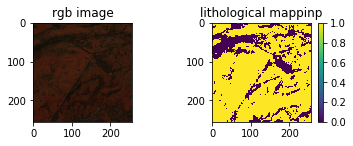

In [3]:
idx = 150
img = np.load(X_trn[idx])
lbl = np.load(Y_trn[idx])

img_rgb = np.transpose(img, [1,2,0])[:,:,::-1][:,:,-3:]
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('rgb image')
plt.subplot(222)
plt.imshow(np.argmax(lbl, axis=0))
plt.colorbar()
plt.title('lithological mappinp')

#### start to build and train Conv2D

In [4]:
conv = myModel()

# build Conv2D
conv.build_SegmentorNet(n_ch_list=[64, 64, 64, 64])

# now the tensorboard event file is saved in ./logs
# the training process, graph and statistics can be
# visualize by tensorboard

# compile with loss and optimizer
conv.compile_model(lr=1e-3, verbose=False)

building Unet ...
[64, 64, 64, 64]
[64, 64, 64]
compiling Segmentor only ...


In [5]:
trn_data = DataGenerator(X_trn[:20], Y_trn[:20], batch_size=10, dtype='sent')
vld_data = DataGenerator(X_vld[:20], Y_vld[:20], batch_size=10, dtype='sent')

#### check data generator

In [6]:
x, y = trn_data.getitem(1)

Text(0.5,1,'label')

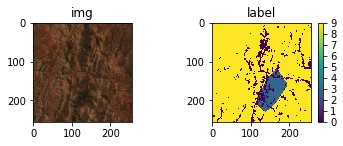

In [7]:
idx = 4
plt.subplot(221)
plt.imshow(2*x[idx,:,:,:][:,:,::-1][:,:,-3:])
plt.title('img')
plt.subplot(222)
plt.imshow(np.argmax(y[idx,:,:,:], axis=-1))
plt.colorbar()
plt.title('label')

In [9]:
conv.fit_Segmentor_generator(trn_data, vld_data, num_epochs=2)

Epoch 1/2
2/2 [==============================] - 60s 30s/step - loss: 2.2172 - acc: 0.1328 - val_loss: 1.9750 - val_acc: 0.1329

Epoch 00001: val_acc improved from -inf to 0.13291, saving model to ./Segmentor/weights-01-0.13.hdf5
Epoch 2/2
2/2 [==============================] - 56s 28s/step - loss: 2.0346 - acc: 0.1561 - val_loss: 1.8747 - val_acc: 0.2798

Epoch 00002: val_acc improved from 0.13291 to 0.27976, saving model to ./Segmentor/weights-02-0.28.hdf5


#### predict on test data

In [16]:
# conv.save_weights('./Conv2D/weights-11-.hdf5')
# conv.save_weights(suffix='sent_geo')
conv.load_weights('./weights/Unet-4X64-0.38.hdf5')

In [17]:
tst_data = DataGenerator(X_tst, Y_tst, batch_size=100)

In [19]:
xx, yy = tst_data.getitem(0)

In [21]:
Y_preds = conv.predict(X_tst=xx)

100/100 [==============================] - 170s 2s/step


#### visualize predicted Y

Text(0.5,1,'prediction')

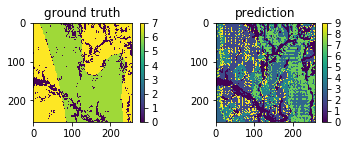

In [33]:
idx = 60
_pred = np.argmax(Y_preds[idx,:,:,:], axis=0)
_tst = np.argmax(yy[idx,:,:,:], axis=0)
plt.subplot(221)
plt.imshow(_tst)
plt.colorbar()
plt.title('ground truth')
plt.subplot(222)
plt.imshow(_pred)
plt.colorbar()
plt.title('prediction')

#### calculate the accuracy

In [26]:
acc_list = []
for i in range(yy.shape[0]):
    tmp_pred = np.argmax(Y_preds[i,:,:,:], axis=2)
    tmp_tst = np.argmax(yy[i,:,:,:], axis=2)
    acc_list.append(np.where(tmp_pred == tmp_tst)[0].shape[0]/(256*256))
print('mean accuracy on test data is {0}, std is {1}'.format(np.mean(acc_list), np.std(acc_list)))
print('max is {0}, min is {1}'.format(max(acc_list), min(acc_list)))

mean accuracy on test data is 0.0149053955078125, std is 0.0031334715397337274
max is 0.021270751953125, min is 0.00531005859375
